In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [3]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [4]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [5]:
def getTimes(gal, cen, ifnumb=False):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+cen)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    z, SFR, MedFeH, MedOFe = [], [], [], []
    EMedFeH, EMedOFe = [], []
    numb = []
    
    zi = 0
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        offGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        SFRs = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][offGas[0]:offGas[1]]
        Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][offGas[0]:offGas[1]]
        
        totSFR = np.sum(SFRs)
        
        FeH = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun
        OFe = np.log10((Abundances[:,3]/OMass)/(Abundances[:,4]/FeMass)) - NoNfe_sun
        
        ife = np.where((np.isnan(FeH)==False) & (np.isinf(FeH)==False))
        io = np.where((np.isnan(OFe)==False) & (np.isinf(OFe)==False))
        
        FeH = FeH[ife]
        OFe = OFe[io]
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][idd]
        groupC = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        if group==groupC:
            zi = zs
        
        z.append(zs)
        SFR.append(totSFR)
        MedFeH.append(np.median(FeH))
        MedOFe.append(np.median(OFe))
        
        EMedFeH.append(np.std(FeH)/np.sqrt(FeH.size)*np.sqrt(np.pi/2.))
        EMedOFe.append(np.std(OFe)/np.sqrt(OFe.size)*np.sqrt(np.pi/2.))
        numb.append(OFe.size)
        
    z, SFR, MedFeH, MedOFe = np.array(z), np.array(SFR), np.array(MedFeH), np.array(MedOFe)
    EMedFeH, EMedOFe = np.array(EMedFeH), np.array(EMedOFe)
    numb = np.array(numb)
    
#     maxSFR = SFR.max()
#     i = np.where(SFR==maxSFR)[0][0]
    
#     zi = z[i]
    iz = np.where(z<=zi)

    if ifnumb:
        return z[iz], SFR[iz], MedFeH[iz], MedOFe[iz], zi, EMedFeH[iz], EMedOFe[iz], numb[iz]
    else:
        return z[iz], SFR[iz], MedFeH[iz], MedOFe[iz], zi, EMedFeH[iz], EMedOFe[iz]

In [6]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [7]:
z_1, SFR_1, MedFeH_1, MedOFe_1, zi_1, EMedFeH_1, EMedOFe_1 = getTimes(4338, 4337)
z_2, SFR_2, MedFeH_2, MedOFe_2, zi_2, EMedFeH_2, EMedOFe_2 = getTimes(4341, 4337)
z_3, SFR_3, MedFeH_3, MedOFe_3, zi_3, EMedFeH_3, EMedOFe_3 = getTimes(4470, 4469)
z_4, SFR_4, MedFeH_4, MedOFe_4, zi_4, EMedFeH_4, EMedOFe_4 = getTimes(4474, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount

Text(0, 0.5, '[O/Fe]')

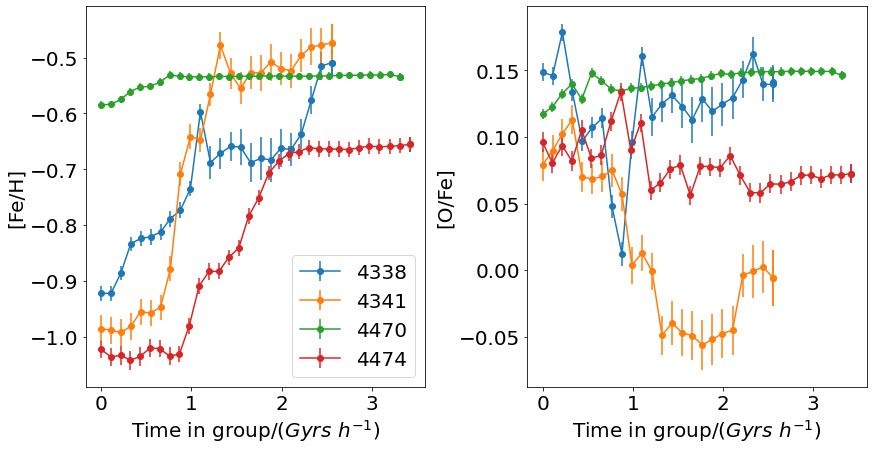

In [8]:
timeM_1 = Cosmo.lookback_time(zi_1).value
time_1 = Cosmo.lookback_time(z_1).value
Dtime_1 = timeM_1 - time_1

timeM_2 = Cosmo.lookback_time(zi_2).value
time_2 = Cosmo.lookback_time(z_2).value
Dtime_2 = timeM_2 - time_2

timeM_3 = Cosmo.lookback_time(zi_3).value
time_3 = Cosmo.lookback_time(z_3).value
Dtime_3 = timeM_3 - time_3

timeM_4 = Cosmo.lookback_time(zi_4).value
time_4 = Cosmo.lookback_time(z_4).value
Dtime_4 = timeM_4 - time_4


pl.figure(figsize=(14,7))
pl.subplots_adjust(wspace=0.3)

pl.subplot(1,2,1)

pl.errorbar(Dtime_1, MedFeH_1, yerr=EMedFeH_1, marker='o', label='4338')
pl.errorbar(Dtime_2, MedFeH_2, yerr=EMedFeH_2, marker='o', label='4341')
pl.errorbar(Dtime_3, MedFeH_3, yerr=EMedFeH_3, marker='o', label='4470')
pl.errorbar(Dtime_4, MedFeH_4, yerr=EMedFeH_4, marker='o', label='4474')

pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[Fe/H]')

pl.subplot(1,2,2)

pl.errorbar(Dtime_1, MedOFe_1, yerr=EMedOFe_1, marker='o')
pl.errorbar(Dtime_2, MedOFe_2, yerr=EMedOFe_2, marker='o')
pl.errorbar(Dtime_3, MedOFe_3, yerr=EMedOFe_3, marker='o')
pl.errorbar(Dtime_4, MedOFe_4, yerr=EMedOFe_4, marker='o')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[O/Fe]')


Text(0, 0.5, '[O/Fe]')

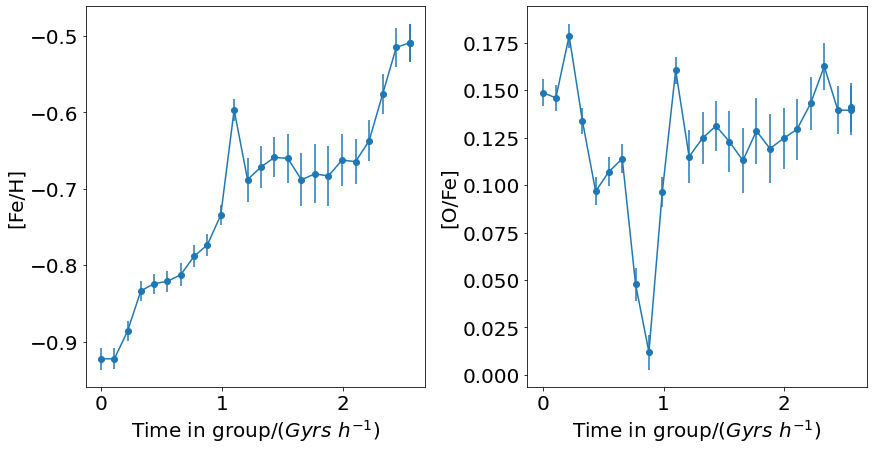

In [9]:
pl.figure(figsize=(14,7))
pl.subplots_adjust(wspace=0.3)

pl.subplot(1,2,1)

pl.errorbar(Dtime_1, MedFeH_1, yerr=EMedFeH_1, marker='o', label='4338')
# pl.errorbar(Dtime_2, MedFeH_2, yerr=EMedFeH_2, marker='o', label='4341')
# pl.errorbar(Dtime_3, MedFeH_3, yerr=EMedFeH_3, marker='o', label='4470')
# pl.errorbar(Dtime_4, MedFeH_4, yerr=EMedFeH_4, marker='o', label='4474')

# pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[Fe/H]')

pl.subplot(1,2,2)

pl.errorbar(Dtime_1, MedOFe_1, yerr=EMedOFe_1, marker='o')
# pl.errorbar(Dtime_2, MedOFe_2, yerr=EMedOFe_2, marker='o')
# pl.errorbar(Dtime_3, MedOFe_3, yerr=EMedOFe_3, marker='o')
# pl.errorbar(Dtime_4, MedOFe_4, yerr=EMedOFe_4, marker='o')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[O/Fe]')


Text(0, 0.5, '[O/Fe]')

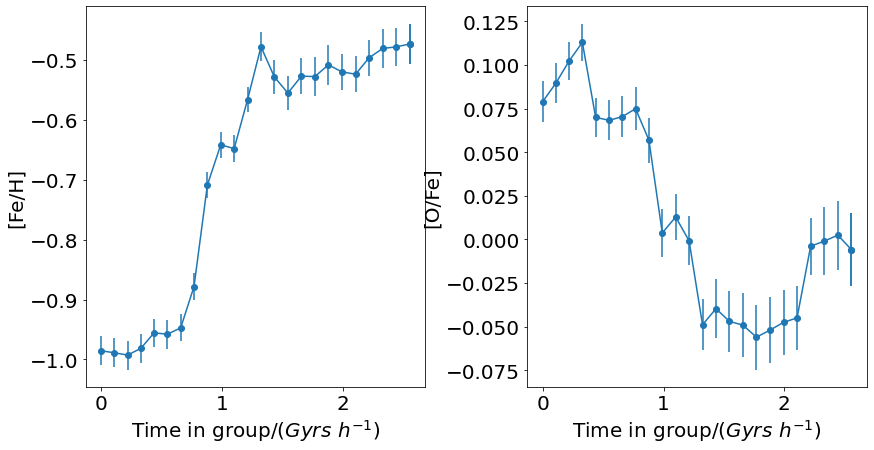

In [10]:
pl.figure(figsize=(14,7))
pl.subplots_adjust(wspace=0.3)

pl.subplot(1,2,1)

# pl.errorbar(Dtime_1, MedFeH_1, yerr=EMedFeH_1, marker='o', label='4338')
pl.errorbar(Dtime_2, MedFeH_2, yerr=EMedFeH_2, marker='o', label='4341')
# pl.errorbar(Dtime_3, MedFeH_3, yerr=EMedFeH_3, marker='o', label='4470')
# pl.errorbar(Dtime_4, MedFeH_4, yerr=EMedFeH_4, marker='o', label='4474')

# pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[Fe/H]')

pl.subplot(1,2,2)

# pl.errorbar(Dtime_1, MedOFe_1, yerr=EMedOFe_1, marker='o')
pl.errorbar(Dtime_2, MedOFe_2, yerr=EMedOFe_2, marker='o')
# pl.errorbar(Dtime_3, MedOFe_3, yerr=EMedOFe_3, marker='o')
# pl.errorbar(Dtime_4, MedOFe_4, yerr=EMedOFe_4, marker='o')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[O/Fe]')

Text(0, 0.5, '[O/Fe]')

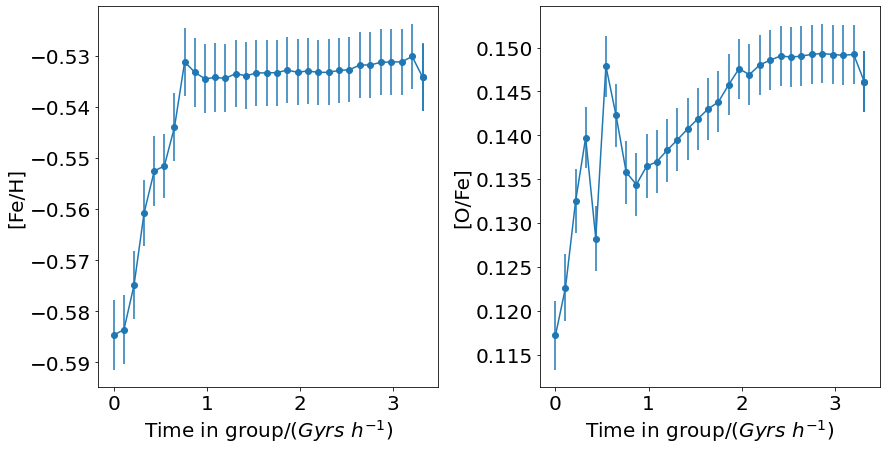

In [11]:
pl.figure(figsize=(14,7))
pl.subplots_adjust(wspace=0.3)

pl.subplot(1,2,1)

# pl.errorbar(Dtime_1, MedFeH_1, yerr=EMedFeH_1, marker='o', label='4338')
# pl.errorbar(Dtime_2, MedFeH_2, yerr=EMedFeH_2, marker='o', label='4341')
pl.errorbar(Dtime_3, MedFeH_3, yerr=EMedFeH_3, marker='o', label='4470')
# pl.errorbar(Dtime_4, MedFeH_4, yerr=EMedFeH_4, marker='o', label='4474')

# pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[Fe/H]')

pl.subplot(1,2,2)

# pl.errorbar(Dtime_1, MedOFe_1, yerr=EMedOFe_1, marker='o')
# pl.errorbar(Dtime_2, MedOFe_2, yerr=EMedOFe_2, marker='o')
pl.errorbar(Dtime_3, MedOFe_3, yerr=EMedOFe_3, marker='o')
# pl.errorbar(Dtime_4, MedOFe_4, yerr=EMedOFe_4, marker='o')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[O/Fe]')

Text(0, 0.5, '[O/Fe]')

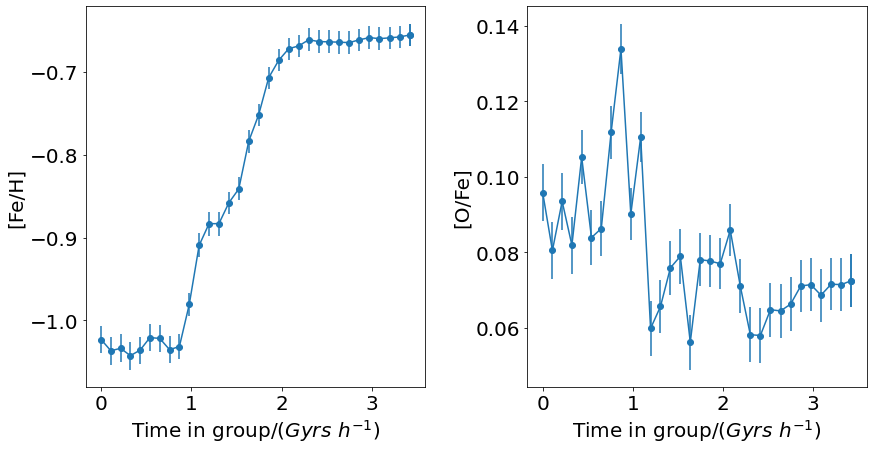

In [12]:
pl.figure(figsize=(14,7))
pl.subplots_adjust(wspace=0.3)

pl.subplot(1,2,1)

# pl.errorbar(Dtime_1, MedFeH_1, yerr=EMedFeH_1, marker='o', label='4338')
# pl.errorbar(Dtime_2, MedFeH_2, yerr=EMedFeH_2, marker='o', label='4341')
# pl.errorbar(Dtime_3, MedFeH_3, yerr=EMedFeH_3, marker='o', label='4470')
pl.errorbar(Dtime_4, MedFeH_4, yerr=EMedFeH_4, marker='o', label='4474')

# pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[Fe/H]')

pl.subplot(1,2,2)

# pl.errorbar(Dtime_1, MedOFe_1, yerr=EMedOFe_1, marker='o')
# pl.errorbar(Dtime_2, MedOFe_2, yerr=EMedOFe_2, marker='o')
# pl.errorbar(Dtime_3, MedOFe_3, yerr=EMedOFe_3, marker='o')
pl.errorbar(Dtime_4, MedOFe_4, yerr=EMedOFe_4, marker='o')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[O/Fe]')

In [13]:
Slist = h5py.File('SatelliteList_V2_withAngles_n500_KoK04.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]
Satellites.size

11

Text(0.5, 0, 'r/r_200')

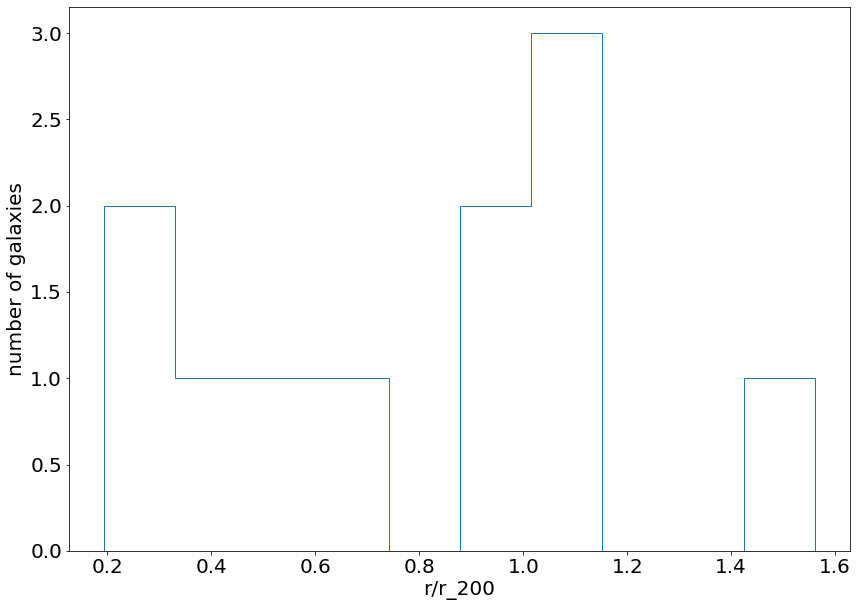

In [14]:
# lets test somo clean up by separation.
R200, GalCen, GroCen = [], [], []

for ss, cc in zip(Satellites, Centrals):
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    galCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    groCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    R200.append(r200)
    GalCen.append(galCen)
    GroCen.append(groCen)

R200, GalCen, GroCen = np.array(R200), np.array(GalCen), np.array(GroCen)

sep = GalCen - GroCen
dist = np.sqrt(sep[:,0]**2+sep[:,1]**2+sep[:,2]**2)
dist = dist/R200

# Satellites = Slist['SatelliteList'][()]
# Centrals = Slist['SatelliteCentral'][()]
# CosCen = Slist['CosCen'][()]
# CosVel = Slist['CosVel'][()]
# LzL = Slist['LZ_L'][()]

pl.figure(figsize=(14, 10))

pl.hist(dist, histtype='step')
pl.ylabel('number of galaxies')
pl.xlabel('r/r_200')

In [15]:
ir = np.where(dist>0.5)

Satellites = Satellites[ir]
Centrals = Centrals[ir]

Satellites.size

8

In [16]:
# ok, how we make this, just add stuff i think

Time, SFRs, MedFeHs, MedOFes = [], [], [], []
Numb = []

# pl.figure(figsize=(14,7))

for sat, cen in zip(Satellites, Centrals):
    z, SFR, MedFeH, MedOFe, zi, EMedFeH, EMedOFe, nn = getTimes(sat, cen, True)
    timeM = Cosmo.lookback_time(zi).value
    time = Cosmo.lookback_time(z).value
    Dtime = timeM - time
    
    Time.extend(list(Dtime))
    SFRs.extend(list(SFR))
    MedFeHs.extend(list(MedFeH))
    MedOFes.extend(list(MedOFe))
    
    Numb.extend(list(nn))
    
#     pl.subplot(1,2,1)
#     pl.errorbar(Dtime, MedFeH, yerr=EMedFeH, label='{}'.format(sat))
    
#     pl.subplot(1,2,2)
#     pl.errorbar(Dtime, MedOFe, yerr=EMedOFe, label='{}'.format(sat))
    
# pl.legend(loc='best', ncol=2)
    
Time, SFRs, MedFeHs, MedOFes = np.array(Time), np.array(SFRs), np.array(MedFeHs), np.array(MedOFes)
Numb = np.array(Numb)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount

In [17]:
iT = np.where((np.isnan(MedFeHs)==False) & ((np.isnan(MedOFes)==False)) & (Numb>=500))[0]

Time, SFRs, MedFeHs, MedOFes = Time[iT], SFRs[iT], MedFeHs[iT], MedOFes[iT]

medFEH, bins, zipC = sp.binned_statistic(Time, MedFeHs, statistic='median', bins=10)
medOFE, bins, zipC = sp.binned_statistic(Time, MedOFes, statistic='median', bins=10)

numbFEH, bins, zipC = sp.binned_statistic(Time, MedFeHs, statistic='count', bins=10)
numbOFE, bins, zipC = sp.binned_statistic(Time, MedOFes, statistic='count', bins=10)

stdFEH, bins, zipC = sp.binned_statistic(Time, MedFeHs, statistic='std', bins=10)
stdOFE, bins, zipC = sp.binned_statistic(Time, MedOFes, statistic='std', bins=10)

errFEH = stdFEH/np.sqrt(numbFEH)*np.sqrt(np.pi/2.)
errOFE = stdOFE/np.sqrt(numbOFE)*np.sqrt(np.pi/2.)



Text(0, 0.5, '[O/Fe]')

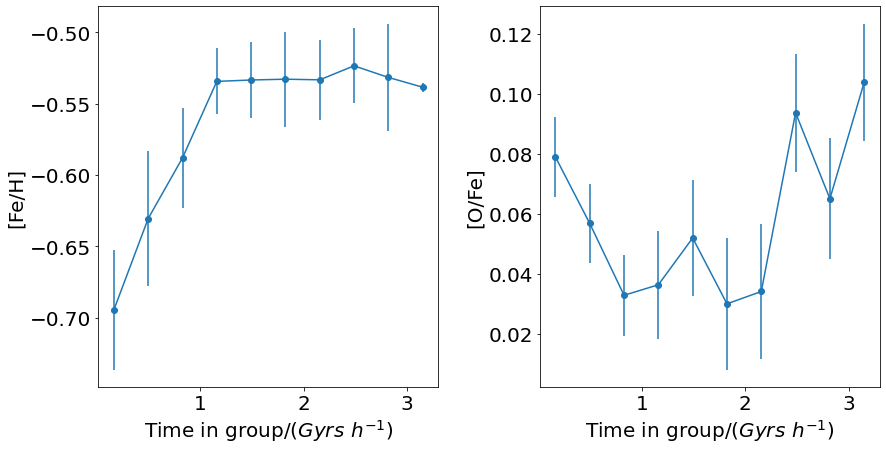

In [18]:
pl.figure(figsize=(14,7))
pl.subplots_adjust(wspace=0.3)

xTime = 0.5*(bins[:-1]+bins[1:])

pl.subplot(1,2,1)

pl.errorbar(xTime, medFEH, yerr=errFEH, marker='o', label='4474')

# pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[Fe/H]')

pl.subplot(1,2,2)

pl.errorbar(xTime, medOFE, yerr=errOFE, marker='o')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('[O/Fe]')

In [19]:
# ok, this is a change, let see something differente
sim['SnapNumber_128/SubGroups'].keys()

<KeysViewHDF5 ['Apertures', 'GroupNumber', 'OpticalRadius', 'PartType0', 'PartType1', 'PartType4', 'PartType5', 'SnapNumber', 'SubFindNumber', 'SubGroupHalfMass', 'SubGroupLen', 'SubGroupMostBoundID', 'SubGroupNumber', 'SubGroupPos', 'SubGroupSpin', 'SubGroupVel', 'SubGroupVelDisp', 'SubGroupVelMax']>

In [20]:
sim['SnapNumber_128/SubGroups/OpticalRadius'].attrs['description_units']

'$h^{-1} ckpc$'

In [21]:
G = 4.3*1e-6 # kpc/M_sun km^2/s^2
multfac = 3.086/3.17098 # to get time in Gyrs, lets see

In [22]:
T, Trot = [], []

for sat, cen in zip(Satellites, Centrals):
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][sat]
    GMass = sim['SnapNumber_128/Groups/Group_M_Crit200'][group]
    mu = G*GMass*1e10
    posC = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
    posG = sim['SnapNumber_128/SubGroups/SubGroupPos'][sat]
    velC = sim['SnapNumber_128/SubGroups/SubGroupVel'][cen]
    velG = sim['SnapNumber_128/SubGroups/SubGroupVel'][sat]
    
    vel = velG-velC
    vvel = np.sqrt(np.sum(vel**2.))
    pos = posG-posC
    ppos = np.sqrt(np.sum(pos**2.))
    
    a = mu*ppos/(2*mu-ppos*vvel**2)
    
    if a<0:
        print(ppos, sim['SnapNumber_128/Groups/Group_M_Crit200'][group], sat)
    else:
        print(a, mu)
    T1 = 2.*np.pi*np.sqrt(a**3./mu)
    T2 = T1*multfac
    T.append(T2)
    
    R = sim['SnapNumber_128/SubGroups/OpticalRadius'][sat]
    off = sim['SnapNumber_128/SubGroups/PartType1/Offsets'][sat]
    Mu = G*(off[1]-off[0])*0.00010843*1e10
    T3 = 2.*np.pi*np.sqrt(R**3./Mu)
    T4 = T3*multfac
    Trot.append(T4)
    
T = np.array(T)
Trot = np.array(Trot)
T, Trot

81.99997352476477 55461.83776855469
93.12606847989109 4094617.195129394
100.6415362208818 4094617.195129394
43.01149286883969 4094617.195129394
65.55322380743375 2572278.686523437
111.54567596342038 2572278.686523437
126.54488 59.820435 4476
312.3382232046744 2572278.686523437


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


(array([19.27994219,  2.71570466,  3.05099517,  0.8524176 ,  2.02355195,
         4.49161359,         nan, 21.04558396]),
 array([0.08928887, 0.38890986, 0.38374701, 0.54006655, 0.23553747,
        0.13247725, 0.21881833, 0.1107846 ]))

In [23]:
# ill take a look at 4476 orbits

uniqueID = int(128*1e6+4476)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))
   
uniqueIDC = int(128*1e6+4469)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
X, Y, Z = [], [], []
    
for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
    
    posC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    posG = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    
    pos = posG-posC
    X.append(pos[0])
    Y.append(pos[1])
    Z.append(pos[2])
    
X, Y, Z = np.array(X), np.array(Y), np.array(Z)

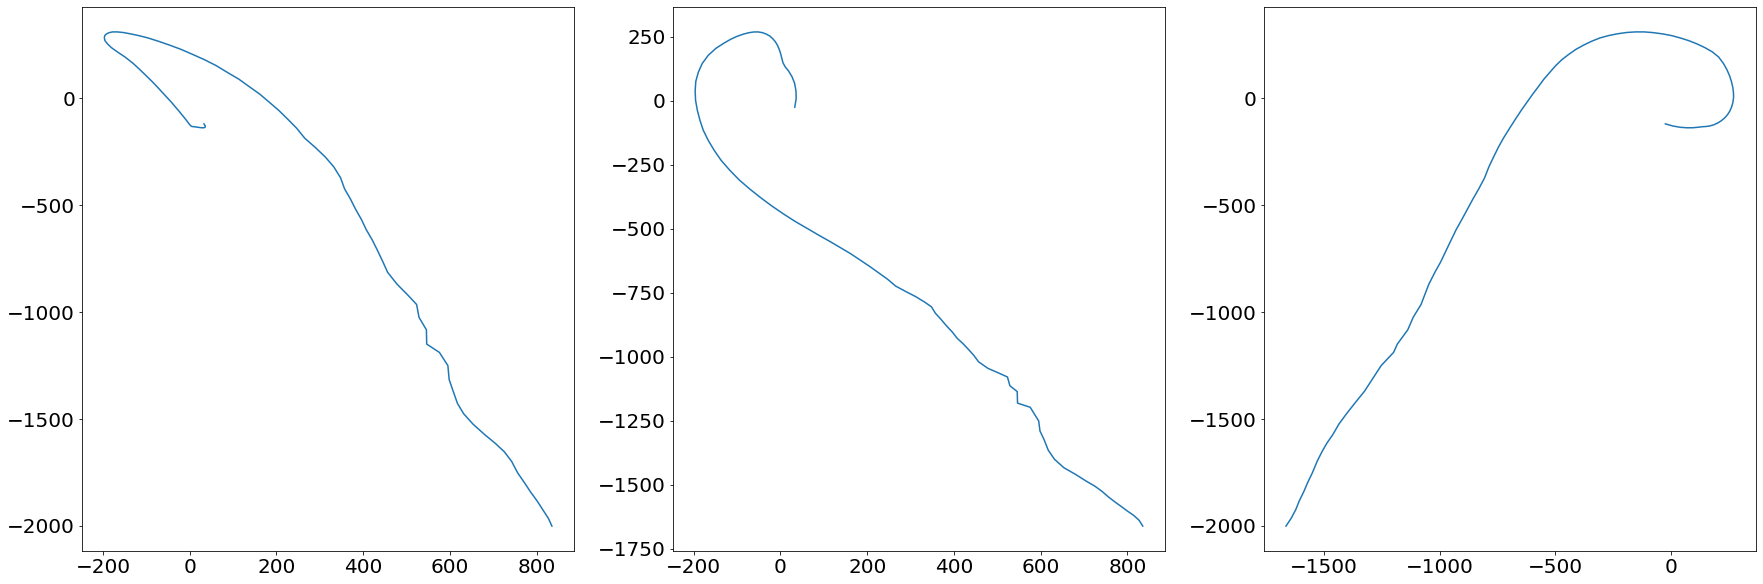

In [24]:
pl.figure(figsize=(30, 10))

pl.subplot(1, 3, 1)

pl.plot(X, Y)

pl.subplot(1, 3, 2)

pl.plot(X, Z)

pl.subplot(1, 3, 3)

pl.plot(Z, Y)


In [25]:
# ok, i dont now what to do with this one, i thing I will ignore it
# ok, how we make this, just add stuff i think

TimeT, TimeP, SFRs, MedFeHs, MedOFes = [], [], [], [], []
Numb = []

for sat, cen, t, tr in zip(Satellites, Centrals, T, Trot):
    z, SFR, MedFeH, MedOFe, zi, EMedFeH, EMedOFe, nn = getTimes(sat, cen, True)
    timeM = Cosmo.lookback_time(zi).value
    time = Cosmo.lookback_time(z).value
    Dtime = timeM - time
    
    
    TimeT.extend(list(Dtime/t))
    TimeP.extend(list(Dtime/tr))
    SFRs.extend(list(SFR))
    MedFeHs.extend(list(MedFeH))
    MedOFes.extend(list(MedOFe))
    
    Numb.extend(list(nn))
    
TimeT, TimeP, SFRs, MedFeHs, MedOFes = np.array(TimeT), np.array(TimeP), np.array(SFRs), np.array(MedFeHs), np.array(MedOFes)
Numb = np.array(Numb)


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount

In [26]:
iT = np.where((np.isnan(MedFeHs)==False) & ((np.isnan(MedOFes)==False)) & ((np.isnan(TimeT)==False)) & (Numb>=500))[0]

TimeT_, SFRs_, MedFeHs_, MedOFes_ = TimeT[iT], SFRs[iT], MedFeHs[iT], MedOFes[iT]

medFEH, bins, zipC = sp.binned_statistic(TimeT_, MedFeHs_, statistic='median', bins=10)
medOFE, bins, zipC = sp.binned_statistic(TimeT_, MedOFes_, statistic='median', bins=10)

numbFEH, bins, zipC = sp.binned_statistic(TimeT_, MedFeHs_, statistic='count', bins=10)
numbOFE, bins, zipC = sp.binned_statistic(TimeT_, MedOFes_, statistic='count', bins=10)

stdFEH, bins, zipC = sp.binned_statistic(TimeT_, MedFeHs_, statistic='std', bins=10)
stdOFE, bins, zipC = sp.binned_statistic(TimeT_, MedOFes_, statistic='std', bins=10)

errFEH = stdFEH/np.sqrt(numbFEH)*np.sqrt(np.pi/2.)
errOFE = stdOFE/np.sqrt(numbOFE)*np.sqrt(np.pi/2.)



Text(0, 0.5, '[O/Fe]')

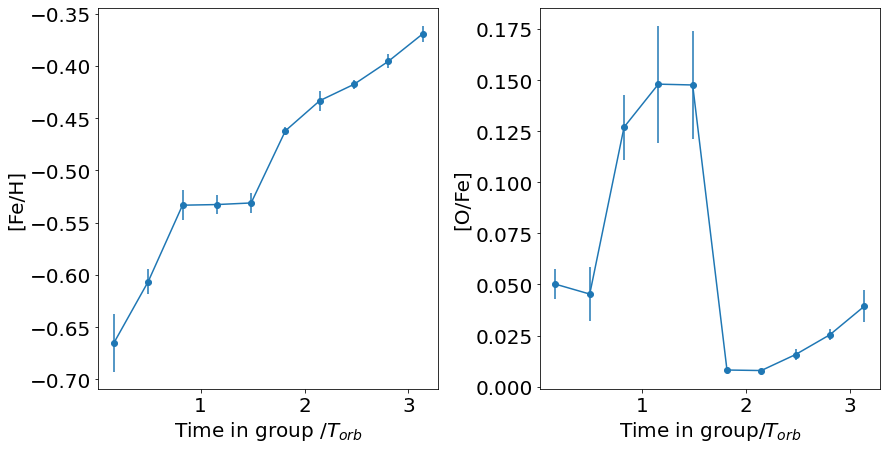

In [27]:
pl.figure(figsize=(14,7))
pl.subplots_adjust(wspace=0.3)

xTime = 0.5*(bins[:-1]+bins[1:])

pl.subplot(1,2,1)

pl.errorbar(xTime, medFEH, yerr=errFEH, marker='o', label='4474')

# pl.legend(loc='best')

pl.xlabel('Time in group $/T_{orb}$')
pl.ylabel('[Fe/H]')

pl.subplot(1,2,2)

pl.errorbar(xTime, medOFE, yerr=errOFE, marker='o')

pl.xlabel('Time in group$/T_{orb}$')
pl.ylabel('[O/Fe]')

In [28]:
iT = np.where((np.isnan(MedFeHs)==False) & ((np.isnan(MedOFes)==False)) & (Numb>=500))[0]

TimeP_, SFRs_, MedFeHs_, MedOFes_ = TimeP[iT], SFRs[iT], MedFeHs[iT], MedOFes[iT]

medFEH, bins, zipC = sp.binned_statistic(TimeP_, MedFeHs_, statistic='median', bins=10)
medOFE, bins, zipC = sp.binned_statistic(TimeP_, MedOFes_, statistic='median', bins=10)

numbFEH, bins, zipC = sp.binned_statistic(TimeP_, MedFeHs_, statistic='count', bins=10)
numbOFE, bins, zipC = sp.binned_statistic(TimeP_, MedOFes_, statistic='count', bins=10)

stdFEH, bins, zipC = sp.binned_statistic(TimeP_, MedFeHs_, statistic='std', bins=10)
stdOFE, bins, zipC = sp.binned_statistic(TimeP_, MedOFes_, statistic='std', bins=10)

errFEH = stdFEH/np.sqrt(numbFEH)*np.sqrt(np.pi/2.)
errOFE = stdOFE/np.sqrt(numbOFE)*np.sqrt(np.pi/2.)

Text(0, 0.5, '[O/Fe]')

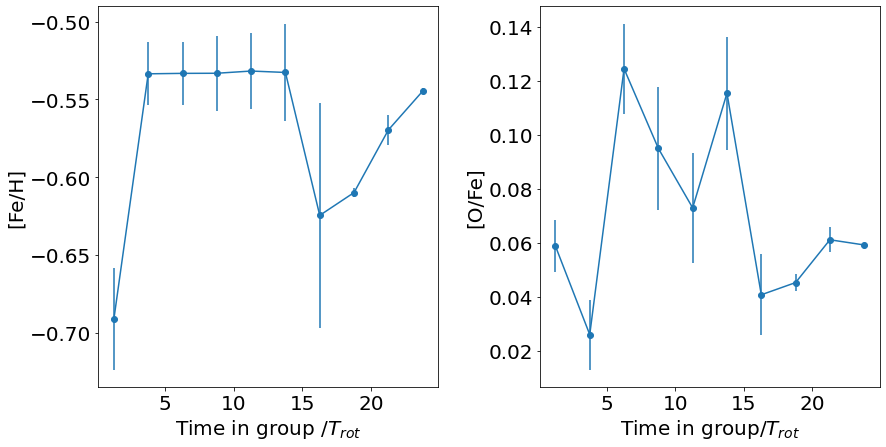

In [29]:
pl.figure(figsize=(14,7))
pl.subplots_adjust(wspace=0.3)

xTime = 0.5*(bins[:-1]+bins[1:])

pl.subplot(1,2,1)

pl.errorbar(xTime, medFEH, yerr=errFEH, marker='o', label='4474')

# pl.legend(loc='best')

pl.xlabel('Time in group $/T_{rot}$')
pl.ylabel('[Fe/H]')

pl.subplot(1,2,2)

pl.errorbar(xTime, medOFE, yerr=errOFE, marker='o')

pl.xlabel('Time in group$/T_{rot}$')
pl.ylabel('[O/Fe]')

In [30]:
def getTimes_number(gal, cen):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+cen)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    z, SFR, MedFeH, MedOFe = [], [], [], []
    EMedFeH, EMedOFe = [], []
    
    zi = 0
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        offGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        SFRs = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][offGas[0]:offGas[1]]
        Abundances = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][offGas[0]:offGas[1]]
        
        totSFR = np.sum(SFRs)
        
        FeH = np.log10((Abundances[:,4]/FeMass)/(Abundances[:,6]/HMass)) - NfeNhe_sun
        OFe = np.log10((Abundances[:,3]/OMass)/(Abundances[:,4]/FeMass)) - NoNfe_sun
        
        ife = np.where((np.isnan(FeH)==False) & (np.isinf(FeH)==False))
        io = np.where((np.isnan(OFe)==False) & (np.isinf(OFe)==False))
        
        FeH = FeH[ife]
        OFe = OFe[io]
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][idd]
        groupC = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        if group==groupC:
            zi = zs
        
        z.append(zs)
        SFR.append(totSFR)
        MedFeH.append(FeH.size)
        MedOFe.append(np.median(OFe))
        
        EMedFeH.append(np.std(FeH)/np.sqrt(FeH.size)*np.sqrt(np.pi/2.))
        EMedOFe.append(np.std(OFe)/np.sqrt(OFe.size)*np.sqrt(np.pi/2.))
        
        
    z, SFR, MedFeH, MedOFe = np.array(z), np.array(SFR), np.array(MedFeH), np.array(MedOFe)
    EMedFeH, EMedOFe = np.array(EMedFeH), np.array(EMedOFe)
    
#     maxSFR = SFR.max()
#     i = np.where(SFR==maxSFR)[0][0]
    
#     zi = z[i]
    iz = np.where(z<=zi)

    return z[iz], SFR[iz], MedFeH[iz], MedOFe[iz], zi, EMedFeH[iz], EMedOFe[iz]

In [31]:
z_1, SFR_1, Mednumbr_1, MedOFe_1, zi_1, EMedFeH_1, EMedOFe_1 = getTimes_number(4343, 4337)
z_2, SFR_2, Mednumbr_2, MedOFe_2, zi_2, EMedFeH_2, EMedOFe_2 = getTimes_number(4476, 4469)
z_3, SFR_3, Mednumbr_3, MedOFe_3, zi_3, EMedFeH_3, EMedOFe_3 = getTimes_number(4478, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [32]:
timeM_1 = Cosmo.lookback_time(zi_1).value
time_1 = Cosmo.lookback_time(z_1).value
Dtime_1 = timeM_1 - time_1

timeM_2 = Cosmo.lookback_time(zi_2).value
time_2 = Cosmo.lookback_time(z_2).value
Dtime_2 = timeM_2 - time_2

timeM_3 = Cosmo.lookback_time(zi_3).value
time_3 = Cosmo.lookback_time(z_3).value
Dtime_3 = timeM_3 - time_3

Text(0, 0.5, 'Number of gas particles')

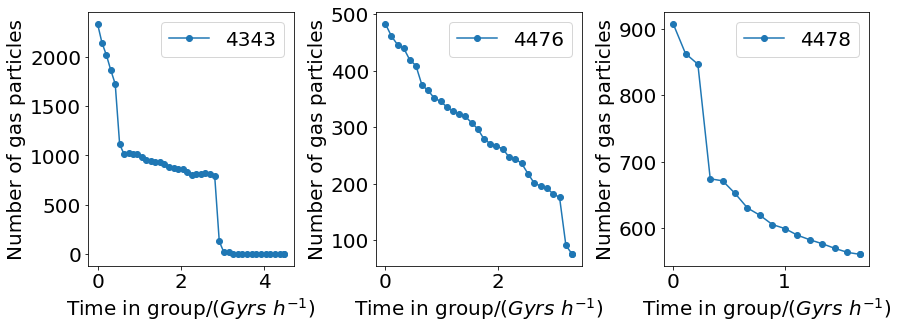

In [33]:
pl.figure(figsize=(14,14/3))
pl.subplots_adjust(wspace=0.4)

pl.subplot(1,3,1)
pl.errorbar(Dtime_1, Mednumbr_1, marker='o', label='4343')
pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('Number of gas particles')

pl.subplot(1,3,2)
pl.errorbar(Dtime_2, Mednumbr_2, marker='o', label='4476')
pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('Number of gas particles')

pl.subplot(1,3,3)
pl.errorbar(Dtime_3, Mednumbr_3, marker='o', label='4478')
pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('Number of gas particles')

In [34]:
z_1, SFR_1, Mednumbr_1, MedOFe_1, zi_1, EMedFeH_1, EMedOFe_1 = getTimes_number(4338, 4337)
z_2, SFR_2, Mednumbr_2, MedOFe_2, zi_2, EMedFeH_2, EMedOFe_2 = getTimes_number(4341, 4337)
z_3, SFR_3, Mednumbr_3, MedOFe_3, zi_3, EMedFeH_3, EMedOFe_3 = getTimes_number(4470, 4469)
z_4, SFR_4, Mednumbr_4, MedOFe_4, zi_4, EMedFeH_4, EMedOFe_4 = getTimes_number(4474, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [35]:
timeM_1 = Cosmo.lookback_time(zi_1).value
time_1 = Cosmo.lookback_time(z_1).value
Dtime_1 = timeM_1 - time_1

timeM_2 = Cosmo.lookback_time(zi_2).value
time_2 = Cosmo.lookback_time(z_2).value
Dtime_2 = timeM_2 - time_2

timeM_3 = Cosmo.lookback_time(zi_3).value
time_3 = Cosmo.lookback_time(z_3).value
Dtime_3 = timeM_3 - time_3

timeM_3 = Cosmo.lookback_time(zi_3).value
time_3 = Cosmo.lookback_time(z_3).value
Dtime_3 = timeM_3 - time_3

timeM_4 = Cosmo.lookback_time(zi_4).value
time_4 = Cosmo.lookback_time(z_4).value
Dtime_4 = timeM_4 - time_4

Text(0, 0.5, 'Number of gas particles')

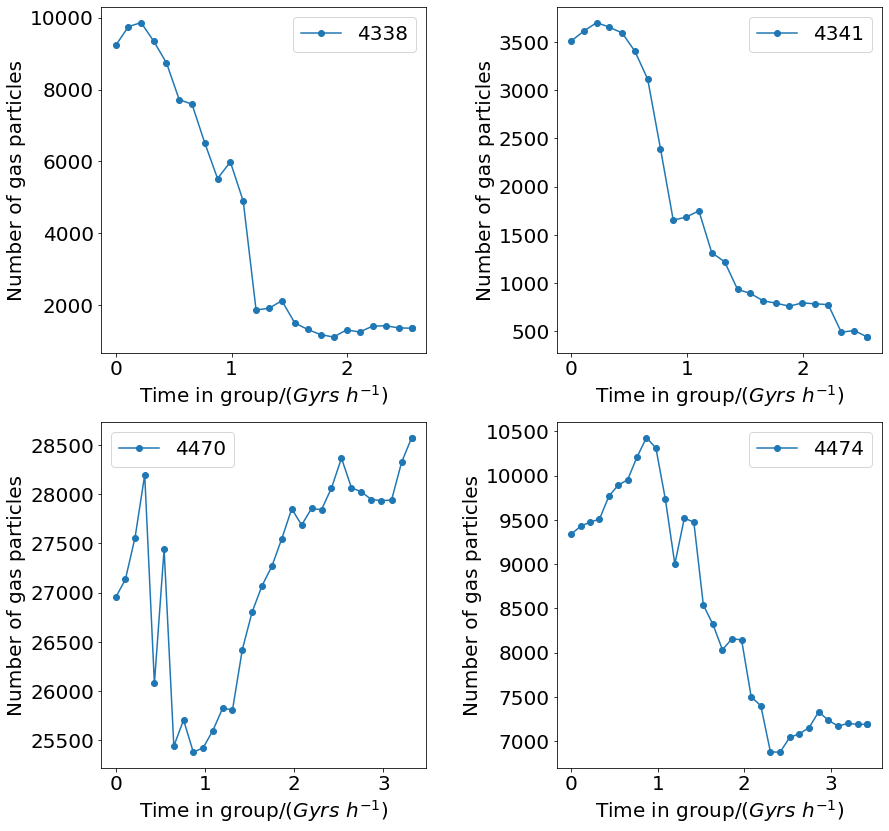

In [36]:
pl.figure(figsize=(14,14))
pl.subplots_adjust(wspace=0.4)

pl.subplot(2,2,1)
pl.errorbar(Dtime_1, Mednumbr_1, marker='o', label='4338')
pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('Number of gas particles')

pl.subplot(2,2,2)
pl.errorbar(Dtime_2, Mednumbr_2, marker='o', label='4341')
pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('Number of gas particles')

pl.subplot(2,2,3)
pl.errorbar(Dtime_3, Mednumbr_3, marker='o', label='4470')
pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('Number of gas particles')

pl.subplot(2,2,4)
pl.errorbar(Dtime_4, Mednumbr_4, marker='o', label='4474')
pl.legend(loc='best')

pl.xlabel('Time in group$/(Gyrs\,\,h^{-1})$')
pl.ylabel('Number of gas particles')